# Analyis inference result dataset

**Objective**: 




# Setup


## Imports

In [ ]:
from ecutilities.ipython import nb_setup, pandas_nrows_ncols
nb_setup()

Set autoreload mode


In [ ]:
import numpy as np
import os
import pandas as pd

from nbdev import show_doc
from pathlib import Path
from pprint import pprint
from tqdm.notebook import trange, tqdm

from ecutilities.ipython import pandas_nrows_ncols
from metagentools.cnn_virus.data import FastaFileReader

## Paths

In [ ]:
# Path to the data directory
p2data = Path(f"../../../data").resolve()
assert p2data.is_dir()

# Path to result datasets
p2results = p2data / 'cov_results/cnn_virus'
assert p2results.is_dir()

# Path to result dataset
seed = 'infer_5yucnk_6'
p2ds = p2results / f"results_all_{seed}.parquet"
assert p2ds.is_file()

# Path to reference sequence fasta file
p2refseqs = p2data / 'cov_data/cov_virus_sequences.fa'
assert p2refseqs.is_file()

## Load reference sequence metadata

In [ ]:
refseq_meta = FastaFileReader(p2refseqs).parse_fasta()
refseq_meta = pd.DataFrame(refseq_meta).T.sort_values(by='taxonomyid')
refseq_meta = refseq_meta.drop_duplicates(subset=['taxonomyid'])
refseq_meta = refseq_meta.set_index(keys='taxonomyid', drop=True).loc[:, ['seqid', 'species']]
refseq_meta

## Load and prepare inference result dataset

In [ ]:
# Load data from parquet format
df = pd.read_parquet(p2ds).sort_index()
print(f"Loaded dataset from parquet: {df.shape[0]:,d} samples")
# Set datatype as they should be
dftypes = {'refseqid': str, 'read_position': int, 'refseq_strand': str, 'preds_label': int, 'preds_pos': int}
df = df.astype(dtype=dftypes)
# Extract taxonomy information from reference sequence ID, as categorical
print('Extracting taxonomy IDs')
df['ref_taxonomy'] = df.refseqid.str.extract(r'(\d*):').astype('category')

In [ ]:
# Add the species name (from refseq metadata)
cols = 'refseqid ref_taxonomy species read_position refseq_strand preds_label preds_pos'.split(' ')
df = pd.merge(
    left=df, right=refseq_meta.species, 
    how='inner', 
    left_on='ref_taxonomy', right_index=True)
df = df.loc[:, cols]

In [ ]:
print(f"Inference for {df.shape[0]:,d} reads from sequence with {df.refseqid.value_counts().shape[0]:,d} unique taxonomy IDs")

Inference for 18,884,844 reads from sequence with 3,300 unique taxonomy IDs


In [ ]:
df.head(3)

,refseqid,ref_taxonomy,species,read_position,refseq_strand,preds_label,preds_pos
1052157:ncbi:2751-1,1052157:ncbi:2751,1052157,Feline coronavirus UU47 scientific name,21794,-,22,8
1052157:ncbi:2751-10,1052157:ncbi:2751,1052157,Feline coronavirus UU47 scientific name,8337,-,32,4
1052157:ncbi:2751-100,1052157:ncbi:2751,1052157,Feline coronavirus UU47 scientific name,21888,-,28,3


In [ ]:
df.sample(3)

,refseqid,ref_taxonomy,species,read_position,refseq_strand,preds_label,preds_pos
1335626:ncbi:2666-2037,1335626:ncbi:2666,1335626,Middle East respiratory syndrome-related coron...,27460,-,94,0
11120:ncbi:438-4861,11120:ncbi:438,11120,Infectious bronchitis virus scientific name,17653,-,62,9
11137:ncbi:1768-2442,11137:ncbi:1768,11137,Human coronavirus 229E scientific name,8914,+,12,3


## Prediction evaluation functions (cov, mers and sars)

In [ ]:
# TODO: move functions into metagentools package

def is_cov(y_preds:int|np.ndarray|pd.Series):
    """Return 1 if the corresponding prediction is a corona virus, 0 otherwise"""
    if isinstance(y_preds, int):
        return bool(int(y_preds == 94) + int(y_preds == 117))
    elif isinstance(y_preds, pd.Series) or isinstance(y_preds, np.ndarray):
        return ((y_preds == 94).astype(int) + (y_preds == 117).astype(int)).astype(bool)
    else:
        raise ValueError(f"y_preds should be an int, np.ndarray or pd.Series, not a {type(y_preds)}")

def is_mers(y_preds:int|np.ndarray|pd.Series):
    """Return 1 if the corresponding prediction is a mers virus, 0 otherwise"""
    return y_preds == 94

def is_sars(y_preds:int|np.ndarray|pd.Series):
    """Return 1 if the corresponding prediction is a sars virus, 0 otherwise"""
    return y_preds == 117

def cov_pct(y_preds):
    """Evaluates the accuracy of the model assuming all evaluated reads are from corona virus"""
    acc = is_cov(y_preds).sum()/y_preds.shape[0]
    return acc * 100

def mers_pct(y_preds):
    """Evaluates the accuracy of the model assuming all evaluated reads are from corona virus"""
    acc = is_mers(y_preds).sum()/y_preds.shape[0]
    return acc * 100

def sars_pct(y_preds):
    """Evaluates the accuracy of the model assuming all evaluated reads are from corona virus"""
    acc = is_sars(y_preds).sum()/y_preds.shape[0]
    return acc * 100

# Evaluate performance per taxonomy ID

In [ ]:
df.sample(3)

,refseqid,ref_taxonomy,species,read_position,refseq_strand,preds_label,preds_pos
694009:ncbi:3258-5030,694009:ncbi:3258,694009,Severe acute respiratory syndrome-related coro...,2285,+,117,0
422133:ncbi:977-352,422133:ncbi:977,422133,Sambar deer coronavirus US/OH-WD388-TC/1994 s...,4160,+,13,0
28295:ncbi:974-3299,28295:ncbi:974,28295,Porcine epidemic diarrhea virus scientific name,12929,+,117,8


In [ ]:
by_reftaxonomy = df.groupby(by='ref_taxonomy')

Evaluation table is a DataFrame whose index is the taxonomy ID and the columns are:

- `read_counts`: the number of reads generated from that reference sequence
- `ref_species`: the name of the species corresponding to the reference sequence,
- `cov_pct`: % of reads that were predicted as corona virus,
- `mers_pct`: % of reads that were predicted as MERS virus,
- `sars_pct`: % of reads that were predicted as SARS virus,

In [ ]:
# Create a dataframe with read counts and 
data = {
    'read_counts': by_reftaxonomy.refseqid.count(),
    'cov_pct': by_reftaxonomy.preds_label.aggregate(cov_pct),
    'mers_pct': by_reftaxonomy.preds_label.aggregate(mers_pct),
    'sars_pct': by_reftaxonomy.preds_label.aggregate(sars_pct),
}

results_by_taxonomy = pd.DataFrame(data=data)
print(f"Added average results for {results_by_taxonomy.shape[0]:,d} ")

Added average results for 329 


In [ ]:
results_by_taxonomy.sample(10)

,read_counts,cov_pct,mers_pct,sars_pct
ref_taxonomy,,,,
1477412,5080,4.862205,2.263780,2.598425
11152,49772,6.107852,3.019770,3.088082
2591238,5950,7.563025,3.899160,3.663866
658930,5510,5.716878,2.704174,3.012704
1964806,11060,6.537071,3.471971,3.065099
742003,5940,40.942761,2.996633,37.946128
1766554,22460,7.123776,3.285841,3.837934
1508227,77510,68.235066,1.561089,66.673978
658929,5520,6.123188,2.807971,3.315217


In [ ]:
eval_by_taxonomy = pd.merge(
    left=results_by_taxonomy, 
    right=refseq_meta.species, 
    how='inner', 
    left_index=True, 
    right_index=True).loc[:, ['species', 'read_counts', 'cov_pct', 'mers_pct', 'sars_pct']]
eval_by_taxonomy.index.name = 'taxonomy'
print(f"prediction % for each of {eval_by_taxonomy.shape[0]:,d} taxonomy IDs:")
with pandas_nrows_ncols():
    display(eval_by_taxonomy)

prediction % for each of 329 taxonomy IDs:


,species,read_counts,cov_pct,mers_pct,sars_pct
taxonomy,,,,,
1052157,Feline coronavirus UU47 scientific name,5840,6.780822,3.476027,3.304795
1052158,Feline coronavirus UU54 scientific name,5840,6.301370,3.270548,3.030822
11120,Infectious bronchitis virus scientific name,2391322,6.081741,2.981113,3.100628
11128,Bovine coronavirus scientific name,550649,5.566704,3.027882,2.538822
11135,Feline infectious peritonitis virus scientifi...,35150,7.257468,3.271693,3.985775
11137,Human coronavirus 229E scientific name,211741,7.091210,3.246419,3.844792
11138,Murine hepatitis virus scientific name,61970,5.123447,2.864289,2.259158
11142,Murine hepatitis virus strain A59 scientific ...,12500,5.336000,3.072000,2.264000
11144,Murine hepatitis virus strain JHM scientific ...,6300,5.317460,3.031746,2.285714


### Top 25 taxonomies with highest predicted SARS

In [ ]:
top25_sars = infer_result_ds.sort_values(by='sars_pct', ascending=False).iloc[:25, :]
top25_sars

,species,read_counts,cov_pct,mers_pct,sars_pct
231515,Civet SARS CoV SZ16/2003 scientific name,5940,98.855219,0.067340,98.787879
231513,Civet SARS CoV SZ3/2003 scientific name,5940,98.838384,0.117845,98.720539
1415834,Bat SARS-like coronavirus Rs3367 scientific name,5950,79.210084,1.092437,78.117647
2591235,Coronavirus BtRs-BetaCoV/YN2018B scientific name,6050,78.677686,1.223140,77.454545
1415851,Bat SARS-like coronavirus RsSHC014 scientific...,5950,78.453782,1.092437,77.361345
1739625,SARS-like coronavirus WIV16 scientific name,6050,78.231405,1.256198,76.975207
1415852,Bat SARS-like coronavirus WIV1 scientific name,6060,77.227723,1.287129,75.940594
2591236,Coronavirus BtRs-BetaCoV/YN2018C scientific name,5930,73.507589,1.045531,72.462057
2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,6040,73.708609,1.490066,72.218543
1503303,BtRs-BetaCoV/YN2013 scientific name,5820,72.164948,1.374570,70.790378


### Top 25 taxonomies with highest predicted MERS

In [ ]:
top25_mers = infer_result_ds.sort_values(by='mers_pct', ascending=False).iloc[:25, :]
top25_mers

,species,read_counts,cov_pct,mers_pct,sars_pct
1263720,Betacoronavirus England 1 scientific name,12040,99.626246,99.617940,0.008306
1298362,Human betacoronavirus 2c England-Qatar/2012 s...,6020,99.617940,99.584718,0.033223
1235996,Human betacoronavirus 2c EMC/2012 scientific ...,6020,98.654485,98.588040,0.066445
1306931,Human betacoronavirus 2c Jordan-N3/2012 scien...,12010,98.384679,98.334721,0.049958
1335626,Middle East respiratory syndrome-related coron...,3637262,97.679381,97.572790,0.106591
1368314,Coronavirus Neoromicia/PML-PHE1/RSA/2011 scie...,6020,34.867110,32.441860,2.425249
1495253,BtVs-BetaCoV/SC2013 scientific name,6080,15.115132,12.154605,2.960526
424366,Bat coronavirus HKU5-5 scientific name,6090,11.215107,8.193760,3.021346
424363,Bat coronavirus HKU5-1 scientific name,6090,11.001642,8.128079,2.873563
1965093,Hedgehog coronavirus 1 scientific name,6030,11.558872,8.009950,3.548922


Note: sequences with taxonomyID `2833184` is Sarbecovirus sp.[ncbi](https://www.ncbi.nlm.nih.gov/search/all/?term=2833184)



### Top 25 taxonomies with highest predicted SARS or MERS

In [ ]:
top25_cov = infer_result_ds.sort_values(by='cov_pct', ascending=False).iloc[:25, :]
top25_cov

,species,read_counts,cov_pct,mers_pct,sars_pct
1263720,Betacoronavirus England 1 scientific name,12040,99.626246,99.617940,0.008306
1298362,Human betacoronavirus 2c England-Qatar/2012 s...,6020,99.617940,99.584718,0.033223
231515,Civet SARS CoV SZ16/2003 scientific name,5940,98.855219,0.067340,98.787879
231513,Civet SARS CoV SZ3/2003 scientific name,5940,98.838384,0.117845,98.720539
1235996,Human betacoronavirus 2c EMC/2012 scientific ...,6020,98.654485,98.588040,0.066445
1306931,Human betacoronavirus 2c Jordan-N3/2012 scien...,12010,98.384679,98.334721,0.049958
1335626,Middle East respiratory syndrome-related coron...,3637262,97.679381,97.572790,0.106591
1415834,Bat SARS-like coronavirus Rs3367 scientific name,5950,79.210084,1.092437,78.117647
2591235,Coronavirus BtRs-BetaCoV/YN2018B scientific name,6050,78.677686,1.223140,77.454545
1415851,Bat SARS-like coronavirus RsSHC014 scientific...,5950,78.453782,1.092437,77.361345


### Save tables as excel files

In [ ]:
print(f"Save table for {seed}")

Save table for infer_5yucnk_6


In [ ]:
p2xls = p2data / 'cov_results/xlsx'
assert p2xls.is_dir()

infer_result_ds.to_excel(p2data / f"cov_results/xlsx/all_taxonomies_{seed}.xlsx")
top25_cov.to_excel(p2xls / f"top25_cov_{seed}.xlsx")
top25_mers.to_excel(p2xls / f"top25_mers_{seed}.xlsx")
top25_sars.to_excel(p2xls / f"top25_sars_{seed}.xlsx")

# Filtering results

## Results by taxonomy ID

In [ ]:
pattern = r'(alpha|beta|gamma|delta)coronavirus'

idxs = refseq_meta_df.species.str.match(pattern, case=False).astype(bool)
refseq_meta_df.loc[idxs, :]

,seqid,species
taxonomyid,,
1263720,1263720:ncbi:3171,Betacoronavirus England 1 scientific name
1385427,1385427:ncbi:197,Betacoronavirus Erinaceus/VMC/DEU/2012 scient...
1465644,1465644:ncbi:1639,Deltacoronavirus PDCoV/USA/Illinois121/2014 s...
1477411,1477411:ncbi:104,Deltacoronavirus PDCoV/USA/Illinois133/2014 s...
1477412,1477412:ncbi:3041,Deltacoronavirus PDCoV/USA/Illinois134/2014 s...
1477413,1477413:ncbi:1611,Deltacoronavirus PDCoV/USA/Illinois136/2014 s...
1477414,1477414:ncbi:1401,Deltacoronavirus PDCoV/USA/Ohio137/2014 scien...
1503290,1503290:ncbi:3231,Alphacoronavirus BtMs-AlphaCoV/GS2013 scienti...
1590370,1590370:ncbi:2571,Betacoronavirus HKU24 scientific name


## Full result dataset

In [ ]:
cols = 'refseqid ref_taxonomy species read_position refseq_strand preds_label preds_pos'.split(' ')
annotated_df = pd.merge(left=df, right=refseq_meta_df.species, how='inner', left_on='ref_taxonomy', right_index=True).loc[:, cols]
annotated_df.shape

(18884844, 7)

In [ ]:
annotated_df.sample(10)

,refseqid,ref_taxonomy,species,read_position,refseq_strand,preds_label,preds_pos
1335626:ncbi:902-1553,1335626:ncbi:902,1335626,Middle East respiratory syndrome-related coron...,23197,-,94,2
1335626:ncbi:2695-956,1335626:ncbi:2695,1335626,Middle East respiratory syndrome-related coron...,29402,+,94,9
1384461:ncbi:2803-1108,1384461:ncbi:2803,1384461,Bat coronavirus CDPHE15/USA/2006 scientific name,10350,+,4,8
1335626:ncbi:716-5374,1335626:ncbi:716,1335626,Middle East respiratory syndrome-related coron...,28027,+,94,9
11120:ncbi:1250-1100,11120:ncbi:1250,11120,Infectious bronchitis virus scientific name,3438,+,12,4
1335626:ncbi:1231-3761,1335626:ncbi:1231,1335626,Middle East respiratory syndrome-related coron...,27985,+,94,9
1335626:ncbi:1472-5430,1335626:ncbi:1472,1335626,Middle East respiratory syndrome-related coron...,6666,-,94,7
2833184:ncbi:348-507,2833184:ncbi:348,2833184,None,6229,-,165,5
11120:ncbi:827-2124,11120:ncbi:827,11120,Infectious bronchitis virus scientific name,17054,-,133,3
11128:ncbi:1520-869,11128:ncbi:1520,11128,Bovine coronavirus scientific name,10992,-,6,6


In [ ]:
pattern = r'(alpha|beta|gamma|delta)coronavirus'
pattern = r'coronavirus'

idxs = annotated_df.species.str.match(pattern, case=False).astype(bool)
df.loc[idxs, :].sample(10)

,refseqid,read_position,refseq_strand,preds_label,preds_pos,ref_taxonomy
2591232:ncbi:2609-1531,2591232:ncbi:2609,14596,-,62,6,2591232
2591233:ncbi:159-2730,2591233:ncbi:159,11956,-,117,5,2591233
2591228:ncbi:2979-2521,2591228:ncbi:2979,21057,+,151,8,2591228
2591228:ncbi:2979-2637,2591228:ncbi:2979,26668,-,32,5,2591228
1965089:ncbi:1120-3453,1965089:ncbi:1120,7865,+,79,4,1965089
2591236:ncbi:266-868,2591236:ncbi:266,25394,+,94,7,2591236
2591237:ncbi:1-2103,2591237:ncbi:1,1894,+,117,0,2591237
1964806:ncbi:2683-3549,1964806:ncbi:2683,24195,+,30,0,1964806
1964806:ncbi:2683-3710,1964806:ncbi:2683,5361,-,3,3,1964806
2591229:ncbi:811-4939,2591229:ncbi:811,3206,+,94,9,2591229


# Evaluate with no grouping

## Add prediction evaluate info in dataset

In [ ]:
cols = 'refseqid ref_taxonomy species read_position refseq_strand preds_label preds_pos'.split(' ')
result_df = pd.merge(
    left=df, right=refseq_meta_df.species, 
    how='inner', 
    left_on='ref_taxonomy', right_index=True).loc[:, cols]
result_df.shape

(18884844, 7)

Add column for `cov`, `mers`, `sars`

In [ ]:
result_df.loc[:, 'cov'] = result_df.preds_label.apply(is_cov)
result_df.loc[:, 'mers'] = result_df.preds_label.apply(is_mers)
result_df.loc[:, 'sars'] = result_df.preds_label.apply(is_sars)
result_df.head()

,refseqid,ref_taxonomy,species,read_position,refseq_strand,preds_label,preds_pos,cov,mers,sars
1052157:ncbi:2751-1,1052157:ncbi:2751,1052157,Feline coronavirus UU47 scientific name,21794,-,22,8,False,False,False
1052157:ncbi:2751-10,1052157:ncbi:2751,1052157,Feline coronavirus UU47 scientific name,8337,-,32,4,False,False,False
1052157:ncbi:2751-100,1052157:ncbi:2751,1052157,Feline coronavirus UU47 scientific name,21888,-,28,3,False,False,False
1052157:ncbi:2751-1000,1052157:ncbi:2751,1052157,Feline coronavirus UU47 scientific name,1865,-,161,7,False,False,False
1052157:ncbi:2751-1001,1052157:ncbi:2751,1052157,Feline coronavirus UU47 scientific name,13978,-,0,0,False,False,False


## Transform `taxonomy` into Categorical

In [ ]:
result_df.loc[:, 'cat_taxonomy'] = result_df.loc[:, 'ref_taxonomy'].astype('category')

## Filtering some species

In [ ]:
pattern = r'(alpha|beta|gamma|delta)coronavirus'
pattern = r'coronavirus'

idxs = result_df.species.str.match(pattern, case=False).astype(bool)
filtered = result_df.loc[idxs, :]
filtered.sample(10)

,refseqid,ref_taxonomy,species,read_position,refseq_strand,preds_label,preds_pos,cov,mers,sars
1965089:ncbi:1120-673,1965089:ncbi:1120,1965089,Coronavirus HKU15 scientific name,19240,+,52,3,False,False,False
1964806:ncbi:2683-1008,1964806:ncbi:2683,1964806,Coronavirus AcCoV-JC34 scientific name,9591,+,19,3,False,False,False
2591238:ncbi:1782-1020,2591238:ncbi:1782,2591238,Coronavirus BtRt-BetaCoV/GX2018 scientific name,18166,-,20,7,False,False,False
2591230:ncbi:710-851,2591230:ncbi:710,2591230,Coronavirus BtSk-AlphaCoV/GX2018C scientific ...,20233,-,132,4,False,False,False
2591238:ncbi:1782-3376,2591238:ncbi:1782,2591238,Coronavirus BtRt-BetaCoV/GX2018 scientific name,16290,+,4,6,False,False,False
1965089:ncbi:1120-3998,1965089:ncbi:1120,1965089,Coronavirus HKU15 scientific name,18761,+,117,8,True,False,True
2591238:ncbi:1782-2061,2591238:ncbi:1782,2591238,Coronavirus BtRt-BetaCoV/GX2018 scientific name,11618,-,48,2,False,False,False
1368314:ncbi:509-2693,1368314:ncbi:509,1368314,Coronavirus Neoromicia/PML-PHE1/RSA/2011 scie...,20969,+,94,6,True,True,False
2591237:ncbi:1-1708,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,23477,+,55,9,False,False,False
2591237:ncbi:1-3167,2591237:ncbi:1,2591237,Coronavirus BtRs-BetaCoV/YN2018D scientific name,25542,+,117,8,True,False,True


In [ ]:
filtered.loc[filtered.loc[:, 'cov']]

,refseqid,ref_taxonomy,species,read_position,refseq_strand,preds_label,preds_pos,cov,mers,sars
1368314:ncbi:509-1000,1368314:ncbi:509,1368314,Coronavirus Neoromicia/PML-PHE1/RSA/2011 scie...,255,+,94,0,True,True,False
1368314:ncbi:509-1004,1368314:ncbi:509,1368314,Coronavirus Neoromicia/PML-PHE1/RSA/2011 scie...,12367,+,94,4,True,True,False
1368314:ncbi:509-1007,1368314:ncbi:509,1368314,Coronavirus Neoromicia/PML-PHE1/RSA/2011 scie...,16556,-,94,4,True,True,False
1368314:ncbi:509-101,1368314:ncbi:509,1368314,Coronavirus Neoromicia/PML-PHE1/RSA/2011 scie...,30046,+,94,9,True,True,False
1368314:ncbi:509-1010,1368314:ncbi:509,1368314,Coronavirus Neoromicia/PML-PHE1/RSA/2011 scie...,5260,+,94,0,True,True,False
...,...,...,...,...,...,...,...,...,...,...
2591238:ncbi:1782-959,2591238:ncbi:1782,2591238,Coronavirus BtRt-BetaCoV/GX2018 scientific name,10422,-,117,2,True,False,True
2591238:ncbi:1782-972,2591238:ncbi:1782,2591238,Coronavirus BtRt-BetaCoV/GX2018 scientific name,1249,+,117,7,True,False,True
2591238:ncbi:1782-981,2591238:ncbi:1782,2591238,Coronavirus BtRt-BetaCoV/GX2018 scientific name,5369,+,94,2,True,True,False
2591238:ncbi:1782-984,2591238:ncbi:1782,2591238,Coronavirus BtRt-BetaCoV/GX2018 scientific name,19080,-,117,3,True,False,True


In [ ]:
filtered.loc[~filtered.loc[:, 'cov']]

,refseqid,ref_taxonomy,species,read_position,refseq_strand,preds_label,preds_pos,cov,mers,sars
1368314:ncbi:509-1,1368314:ncbi:509,1368314,Coronavirus Neoromicia/PML-PHE1/RSA/2011 scie...,22420,-,132,1,False,False,False
1368314:ncbi:509-10,1368314:ncbi:509,1368314,Coronavirus Neoromicia/PML-PHE1/RSA/2011 scie...,3099,-,134,5,False,False,False
1368314:ncbi:509-100,1368314:ncbi:509,1368314,Coronavirus Neoromicia/PML-PHE1/RSA/2011 scie...,20064,+,176,6,False,False,False
1368314:ncbi:509-1001,1368314:ncbi:509,1368314,Coronavirus Neoromicia/PML-PHE1/RSA/2011 scie...,29210,+,31,8,False,False,False
1368314:ncbi:509-1002,1368314:ncbi:509,1368314,Coronavirus Neoromicia/PML-PHE1/RSA/2011 scie...,21250,-,149,0,False,False,False
...,...,...,...,...,...,...,...,...,...,...
2591238:ncbi:1782-995,2591238:ncbi:1782,2591238,Coronavirus BtRt-BetaCoV/GX2018 scientific name,10070,+,32,6,False,False,False
2591238:ncbi:1782-996,2591238:ncbi:1782,2591238,Coronavirus BtRt-BetaCoV/GX2018 scientific name,23909,+,56,1,False,False,False
2591238:ncbi:1782-997,2591238:ncbi:1782,2591238,Coronavirus BtRt-BetaCoV/GX2018 scientific name,16246,+,18,1,False,False,False
2591238:ncbi:1782-998,2591238:ncbi:1782,2591238,Coronavirus BtRt-BetaCoV/GX2018 scientific name,26704,-,52,8,False,False,False


## Does the position of the read in the original sequence matter on the detection?

In [ ]:
import matplotlib.pyplot as plt

Plot using 4,721,211 samples (0.25 of total)


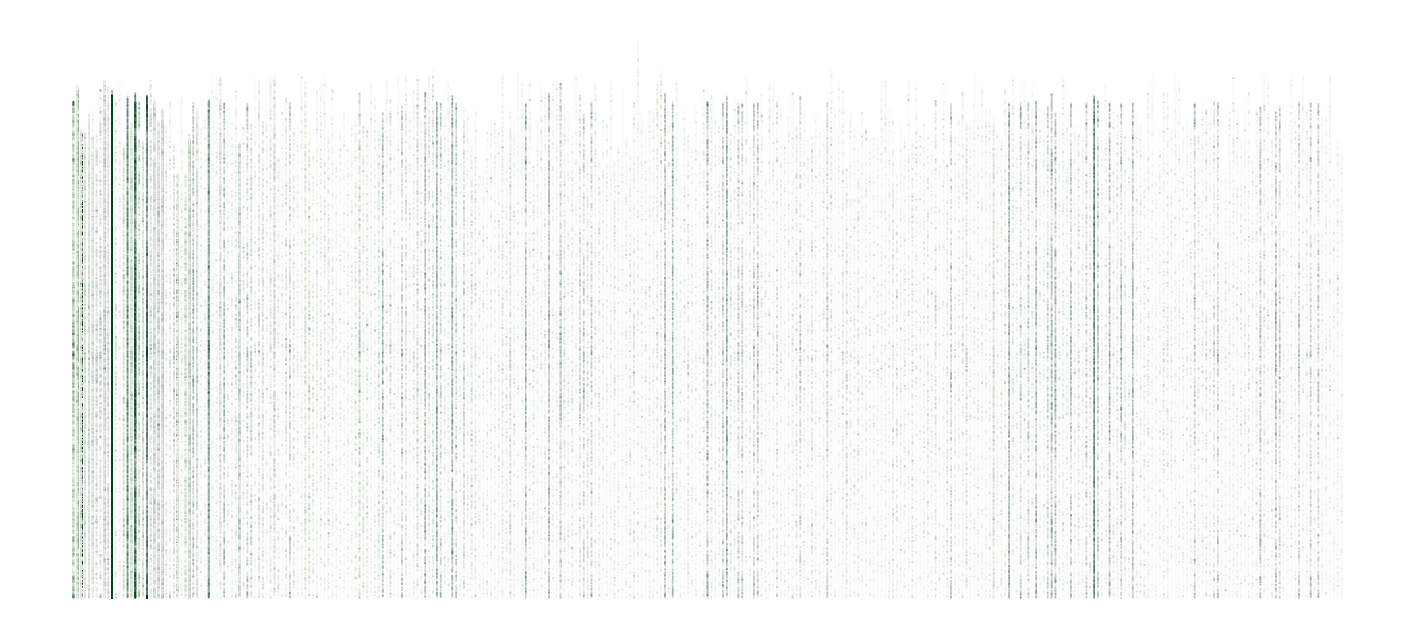

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18,8))
ratio = 0.25
nsamples = int(result_df.shape[0] * ratio)
print(f"Plot using {nsamples:,d} samples ({ratio} of total)")
df_to_plot = result_df.sample(nsamples)
ax.scatter(
    df_to_plot.cat_taxonomy, df_to_plot.read_position,
    s=0.1,
    c=df_to_plot.loc[:, 'cov'], alpha=0.1, cmap='Greens',
)
ax.axis('off')
plt.show()

Plot using 4,721,211 samples (0.25 of total)


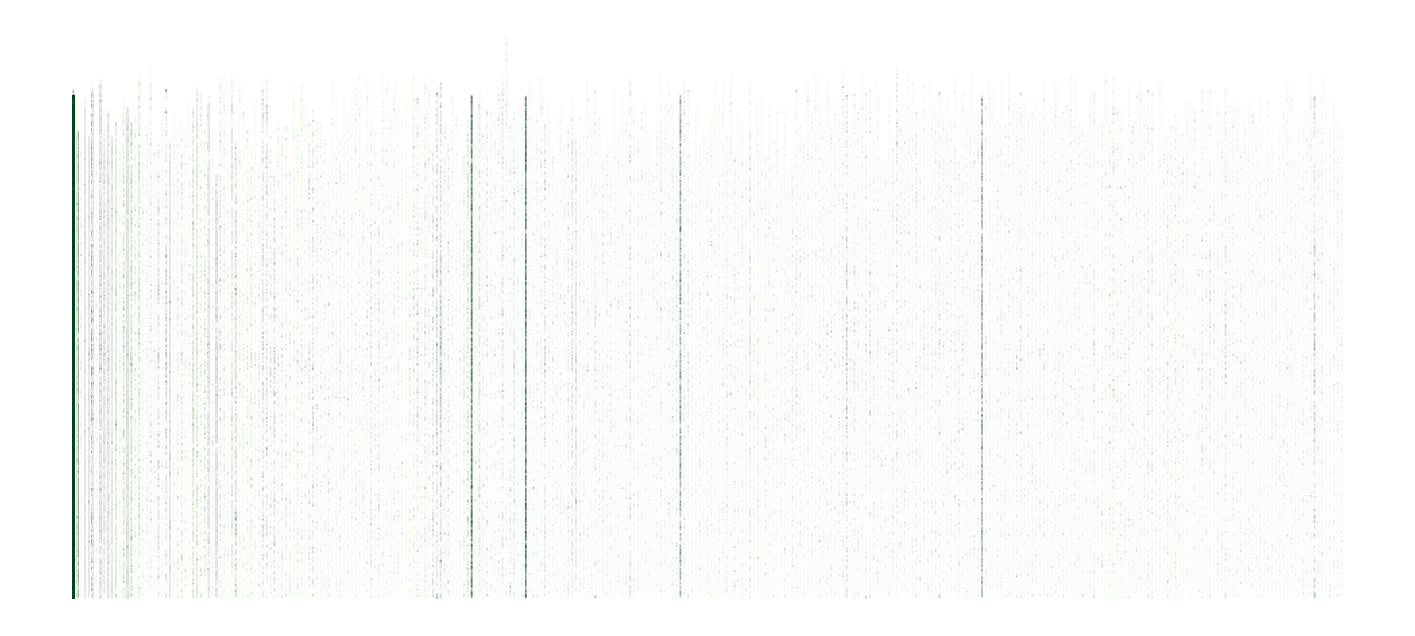

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18,8))
ratio = 0.25
nsamples = int(result_df.shape[0] * ratio)
print(f"Plot using {nsamples:,d} samples ({ratio} of total)")
df_to_plot = result_df.sample(nsamples)
ax.scatter(
    df_to_plot.cat_taxonomy, df_to_plot.read_position,
    s=0.1,
    c=df_to_plot.loc[:, 'mers'], alpha=0.1, cmap='Greens',
)
ax.axis('off')
plt.show()

Plot using 4,721,211 samples (0.25 of total)


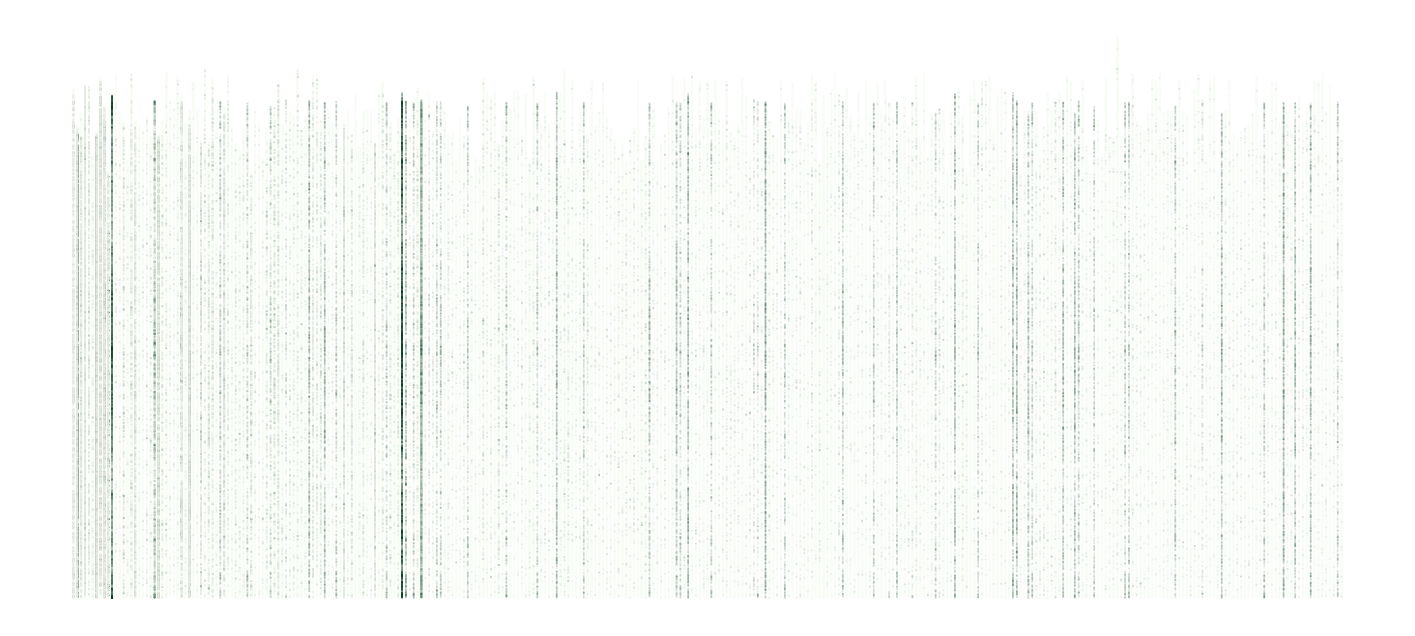

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(18,8))
ratio = 0.25
nsamples = int(result_df.shape[0] * ratio)
print(f"Plot using {nsamples:,d} samples ({ratio} of total)")
df_to_plot = result_df.sample(nsamples)
ax.scatter(
    df_to_plot.cat_taxonomy, df_to_plot.read_position,
    s=0.1,
    c=df_to_plot.loc[:, 'sars'], alpha=0.1, cmap='Greens',
)
ax.axis('off')
plt.show()

Position does not seem to have an obvious impact on whether the prediction is correct or not.

Taxonomy ID has a better predictive value

# Others